## 1. Basic Model

### 1.1 Load files

This code initializes the dataset by loading movie details, competitor schedules, and conversion rates for a TV scheduling and advertising optimization project. It filters movies based on predefined thresholds for viewership potential and prepares competitor data for analysis and optimization.

In [ ]:
# Import necessary libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import xpress as xp

# Define the total number of days and calculate the required slots for scheduling
days = 3
slots_needed = days * 204  # Each day consists of 204 slots (5 minutes per slot)

# Convert the number of slots to match a 30-minute slot requirement for Channel A
channelA_slots = int(204 * days / 6)

# Load the movie database containing details about all available movies
all_movie_df = pd.read_csv('movie_database.csv')

# Filter the movies based on popularity and vote count
# Thresholds are set at the 85th percentile for both 'scaled_popularity' and 'vote_count'
vote_threshold = np.percentile(all_movie_df['vote_count'], 85)
scaled_popularity_threshold = np.percentile(all_movie_df['scaled_popularity'], 85)
movie_df = all_movie_df[
    (all_movie_df['scaled_popularity'] > scaled_popularity_threshold) & 
    (all_movie_df['vote_count'] > vote_threshold)
].reset_index()

# Load schedule data for the three competitor channels and Channel A
# Limit data to the number of required slots and set the index for easier manipulation
channel0 = pd.read_csv('channel_0_schedule.csv')[:slots_needed]
channel1 = pd.read_csv('channel_1_schedule.csv')[:slots_needed]
channel2 = pd.read_csv('channel_2_schedule.csv')[:slots_needed]
channelA = pd.read_csv('channel_A_schedule.csv')[:slots_needed]
channel0.set_index('Unnamed: 0', inplace=True)
channel1.set_index('Unnamed: 0', inplace=True)
channel2.set_index('Unnamed: 0', inplace=True)
channelA.set_index('Unnamed: 0', inplace=True)

# Load conversion rate data for competitor channels (indicating ad effectiveness by genre)
channel0_conversion = pd.read_csv('channel_0_conversion_rates.csv')[:slots_needed]
channel1_conversion = pd.read_csv('channel_1_conversion_rates.csv')[:slots_needed]
channel2_conversion = pd.read_csv('channel_2_conversion_rates.csv')[:slots_needed]
channel0_conversion.set_index('Unnamed: 0', inplace=True)
channel1_conversion.set_index('Unnamed: 0', inplace=True)
channel2_conversion.set_index('Unnamed: 0', inplace=True)

# Store conversion rates in a list for further processing
channel_conversion_list = [channel0_conversion, channel1_conversion, channel2_conversion]

# Store the schedules of competitor channels in a list for subsequent analysis
channel_list = [channel0, channel1, channel2]

### 1.2 Parameters preparation for modelling

Key Functionalities:

Popularity Mapping: Maps movies to their popularity scores for different demographic groups.

Movie Mapping: Establishes bi-directional mappings between movie indices and titles.

Duration Mapping: Associates movies with their runtime in 30-minute slots.

Random Scenario Selection: Randomly selects one of the pre-defined viewership scenarios to simulate stochastic behavior.

Advertisement Identification: Marks advertisement slots for competitor channels for modeling ad placement.

Slot Encoding: Converts slot indices into datetime formats for scheduling purposes, accommodating different slot durations (5 minutes vs. 30 minutes).

Genre Extraction: Extracts unique genres from the dataset for categorization and analysis.

In [ ]:
# Parameters for modeling preparation

# Create a mapping of movie popularity for different age groups (Children, Adults, Retirees)
popularity_mapping = {}
for m in range(len(movie_df)):
    record = movie_df.iloc[m]
    popularity_mapping[m] = [record['children_scaled_popularity']]
    popularity_mapping[m].append(record['adults_scaled_popularity'])
    popularity_mapping[m].append(record['retirees_scaled_popularity'])

# Map movie indices to titles and vice versa
movies_mapping = {m: title for m, title in zip(range(len(movie_df)), movie_df.loc[:, 'title'])}
movies_mapping_inv = {title: m for m, title in zip(range(len(movie_df)), movie_df.loc[:, 'title'])}

# Create a mapping of movie indices to their duration in 30-minute slots
duration = {m: int(d / 30) for m, d in zip(range(len(movie_df)), movie_df.loc[:, 'runtime_with_ads'])}

# Randomly select one of the true viewership scenarios (0 to 9)
import random
truth_random = random.randint(0, 9)

# Calculate expected viewership for each competitor channel based on the chosen scenario
expected = pd.DataFrame({
    'Channel0': list(channel0.loc[:, [
        'children_true_view_count_' + str(truth_random), 
        'adults_true_view_count_' + str(truth_random), 
        'retirees_true_view_count_' + str(truth_random)
    ]].sum(1)),
    'Channel1': list(channel1.loc[:, [
        'children_true_view_count_' + str(truth_random), 
        'adults_true_view_count_' + str(truth_random), 
        'retirees_true_view_count_' + str(truth_random)
    ]].sum(1)),
    'Channel2': list(channel2.loc[:, [
        'children_true_view_count_' + str(truth_random), 
        'adults_true_view_count_' + str(truth_random), 
        'retirees_true_view_count_' + str(truth_random)
    ]].sum(1))
})

# Identify advertisement slots for each competitor channel
channel0_ad = np.where(channel0.loc[:, 'content_type'] == "Advert", 1, 0)
channel1_ad = np.where(channel1.loc[:, 'content_type'] == "Advert", 1, 0)
channel2_ad = np.where(channel2.loc[:, 'content_type'] == "Advert", 1, 0)
channel_ad_slot = pd.DataFrame({
    'Channel0': channel0_ad,
    'Channel1': channel1_ad,
    'Channel2': channel2_ad
})

# Define a function to convert slot encodings into datetime format
from datetime import datetime, timedelta
def encode_to_datetime(encode, length):
    # Base datetime starting from 7:00 AM on October 1, 2024
    base_date = datetime.strptime('2024-10-01 07:00:00', '%Y-%m-%d %H:%M:%S')
    daily_encodings = 204 / (length / 5)  # Calculate the number of slots per day
    
    # Calculate the day and the corresponding slot encoding
    day = encode // daily_encodings
    day_encode = encode % daily_encodings
    
    # Compute the offset in minutes and return the final datetime
    offset_minutes = day_encode * length
    final_date = base_date + timedelta(days=day, minutes=offset_minutes)
    
    return final_date.strftime('%Y-%m-%d %H:%M:%S')

# Create mappings for slots with durations of 30 minutes and 5 minutes
slot_mapping30 = {}
slot_mapping30_inv = {}
for i in range(channelA_slots):
    slot_mapping30[i] = encode_to_datetime(i, 30)
    slot_mapping30_inv[encode_to_datetime(i, 30)] = i

slot_mapping5 = {}
slot_mapping5_inv = {}
for i in range(slots_needed):
    slot_mapping5[i] = encode_to_datetime(i, 5)
    slot_mapping5_inv[encode_to_datetime(i, 5)] = i

# Extract unique genres from the movie dataset
genres = list(movie_df.loc[:, 'genres'])
unique_genres = []
for row in genres:
    splits = row.split("'")
    for split in splits:
        if split in [',', '[', ']', ', ']:
            continue
        if split not in unique_genres:
            unique_genres.append(split)

# Define sets of slots and channels for easier constraint formulation
slots = [i for i in range(slots_needed)]  # All slots (5-minute intervals)
slots_A = [i for i in range(channelA_slots)]  # Channel A slots (30-minute intervals)
channels = [i for i in range(3)]  # Competitor channels (0, 1, and 2)

# Define sets of movies and their indices
movies = list(range(len(movie_df)))  # Indices of filtered movies
all_movies = list(range(len(all_movie_df)))  # Indices of all movies in the database

# Define size variables for indexing and constraints
number_of_movies = len(movie_df)  # Total number of filtered movies
number_of_slots = len(slots)  # Total number of 5-minute slots
number_of_slotsA = len(slots_A)  # Total number of 30-minute slots on Channel A
number_of_channels = len(channels)  # Total number of competitor channels

# Number of slots available (same as total slots for simplicity in this setup)
M = len(slots)

# Prepare lists for advertising slot availability
c_s_list = []  # List of (channel, slot) pairs where advertisements are possible
for s in range(len(channel_ad_slot)):  # Loop through all slots in competitor schedules
    if channel_ad_slot.iloc[s][0] == 1:  # Check if Channel 0 has an ad slot in this slot
        c_s_list.append((0, s))
    if channel_ad_slot.iloc[s][1] == 1:  # Check if Channel 1 has an ad slot in this slot
        c_s_list.append((1, s))
    if channel_ad_slot.iloc[s][2] == 1:  # Check if Channel 2 has an ad slot in this slot
        c_s_list.append((2, s))

# Define list of (channel, slot) pairs where movies are shown
# Exclude slots already reserved for advertisements
movie_slot_list = [(c, s) for c in range(3) for s in range(len(slots)) if (c, s) not in c_s_list]

# Create mappings for (channel, slot) pairs to unique indices and vice versa
c_s_mapping = {(c, s): i for i, (c, s) in enumerate(c_s_list)}  # Map (channel, slot) to index
c_s_mapping_inv = {i: (c, s) for i, (c, s) in enumerate(c_s_list)}  # Map index back to (channel, slot)


**License Fee Calculation**

The calculate_license_fee function computes the licensing fee for each movie using:

A base fee of £10,000.
A budget factor (budget_factor * budget) to scale the licensing fee with the production budget.
A box office revenue factor (box_office_revenue_factor * revenue) to account for the movie's popularity and financial success.
A profit margin (20%) added to the sum of the above.
This calculation ensures that licensing costs reflect both the movie's production value and its market success.

In [ ]:
# Function to calculate license fees for movies based on budget and revenue
def calculate_license_fee(movie_df: pd.DataFrame) -> pd.Series:
    '''
    Calculate the license fee for movies using a base fee, profit margin, and factors
    related to budget and box office revenue.
    '''
    base_fee = 10000  # Fixed base fee for all movies
    profit_margin = 0.2  # Profit margin to be added to the fee
    budget_factor = 0.002  # Factor to scale the movie budget in the fee
    box_office_revenue_factor = 0.001  # Factor to scale the movie's box office revenue in the fee

    # Calculate the license fee formula
    license_fee = (
        base_fee
        + (budget_factor * movie_df.budget)
        + (box_office_revenue_factor * movie_df.revenue)
    ) * (1. + profit_margin)

    # Round the license fee to two decimal places
    return np.round(license_fee, 2)

# Calculate license fees for the filtered movies
license_fee = calculate_license_fee(movie_df)

# Fill missing advertisement slot prices in competitor channels with 0
channel0.loc[:, 'ad_slot_price'] = channel0.loc[:, 'ad_slot_price'].fillna(0)
channel1.loc[:, 'ad_slot_price'] = channel1.loc[:, 'ad_slot_price'].fillna(0)
channel2.loc[:, 'ad_slot_price'] = channel2.loc[:, 'ad_slot_price'].fillna(0)

# Create a mapping from movie indices to their respective license fees
license_fee_mapping = {}
for m in range(len(movie_df)):
    license_fee_mapping[m] = license_fee[m]

**Calculation of competition factor using iterative method**

Key Functionalities:

Genre Encoding: Converts movie genres into a vector for cosine similarity calculations.

Genre Overlap Score: Measures similarity between movies using their genres.

Merging Data: Aligns competitor schedules with the movie database for analysis.

Initial Slot Arrangement: Reads and parses the initial movie schedule to match time slots with movies.

Competition Factor Calculation: Computes the competitive influence of other channels based on genre similarity and scaled popularity, averaged across all competitors.

This logic prepares competition factors, which are used iteratively in subsequent modeling to refine the scheduling strategy for your own channel.

In [ ]:
# Import necessary libraries for numerical computation, data handling, and similarity calculations
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from functools import cache
import ast

# Function to create a genre vector for a movie based on all possible genres
def create_genre_vector(movie_genres: set[str], all_genres: list[str]) -> list[int]:
    '''
    Converts the genres of a movie into a one-hot encoded vector using the vector space
    of all available genres.
    '''
    return [1 if genre in movie_genres else 0 for genre in all_genres]

# Cached function to calculate the genre overlap score between two movies
@cache
def genre_overlap_score(genre_set_A: set[str], genre_set_B: set[str], all_genres: list[str]) -> float:
    '''
    Computes the similarity between two movies based on their genres using
    cosine similarity between their genre vectors.
    '''
    genre_vec_A = create_genre_vector(movie_genres=genre_set_A, all_genres=all_genres)
    genre_vec_B = create_genre_vector(movie_genres=genre_set_B, all_genres=all_genres)
    return cosine_similarity([genre_vec_A], [genre_vec_B])[0, 0]

# List of all unique genres
all_genres = ('Western', 'Adventure', 'Crime', 'Thriller', 'Fantasy', 'Documentary', 'Music',
              'Action', 'TV Movie', 'Drama', 'Mystery', 'Science Fiction', 'Comedy', 'Family',
              'Horror', 'War', 'Animation', 'History', 'Romance')

# Load competitor channel schedules and the movie database
channel_0 = pd.read_csv('channel_0_schedule.csv')
channel_1 = pd.read_csv('channel_1_schedule.csv')
channel_2 = pd.read_csv('channel_2_schedule.csv')
movie_database = pd.read_csv('movie_database.csv')

# Match fields in the competitor schedules with the movie database
channel_0['revenue'] = channel_0['box_office_revenue']
channel_0['scaled_popularity'] = channel_0['movie_popularity_factor']
merged_0 = pd.merge(channel_0, movie_database, on=['revenue', 'scaled_popularity'], how='left')

channel_1['revenue'] = channel_1['box_office_revenue']
channel_1['scaled_popularity'] = channel_1['movie_popularity_factor']
merged_1 = pd.merge(channel_1, movie_database, on=['revenue', 'scaled_popularity'], how='left')

channel_2['revenue'] = channel_2['box_office_revenue']
channel_2['scaled_popularity'] = channel_2['movie_popularity_factor']
merged_2 = pd.merge(channel_2, movie_database, on=['revenue', 'scaled_popularity'], how='left')

# Total slots available for the specified number of days
slots = days * 204
competition_factor = []

# Function to generate a binary matrix from a slot arrangement file
def generate_binary_matrix(file_path):
    '''
    Reads a file containing slot arrangements and converts it into a binary matrix,
    where each row represents a time slot and the corresponding movie.
    '''
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    schedule_list = [eval(line.strip().strip(',')) for line in lines]
    matrix = [[slot_mapping30_inv[i[0]], movies_mapping_inv[i[1]]] for i in schedule_list]

    return matrix

# Generate the initial slot arrangement from a file
initial_slot_arrange = generate_binary_matrix("3days_slot_arrange.txt")

# Compute competition factors for each time slot
for s, m in initial_slot_arrange:
    # Calculate similarity scores with the competitor channels
    channel_0_similarity = genre_overlap_score(
        tuple(ast.literal_eval(movie_database.iloc[m]['genres'])),
        tuple(ast.literal_eval(merged_0.iloc[s]['genres'])),
        all_genres=all_genres
    )
    channel_1_similarity = genre_overlap_score(
        tuple(ast.literal_eval(movie_database.iloc[m]['genres'])),
        tuple(ast.literal_eval(merged_1.iloc[s]['genres'])),
        all_genres=all_genres
    )
    channel_2_similarity = genre_overlap_score(
        tuple(ast.literal_eval(movie_database.iloc[m]['genres'])),
        tuple(ast.literal_eval(merged_2.iloc[s]['genres'])),
        all_genres=all_genres
    )
    
    # Weighted average of similarities using scaled popularity of each channel
    similarity = (channel_0_similarity * channel_0.iloc[s]['scaled_popularity'] +
                  channel_1_similarity * channel_1.iloc[s]['scaled_popularity'] +
                  channel_2_similarity * channel_2.iloc[s]['scaled_popularity'])
    
    competition_factor.append(similarity / 3)


**Conversion Rate Calculation**

Uses genre overlap between advertised movies and surrounding movies to calculate how likely viewers will watch the advertised movie.
Adds stochasticity to mimic real-world variability in viewer behavior.

In [ ]:
# Import necessary libraries for numerical operations, data handling, and similarity calculations
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from functools import cache

# Helper function to create a one-hot encoded vector for movie genres
def create_genre_vector(movie_genres: set[str], all_genres: list[str]) -> list[int]:
    '''
    Converts the genres of a movie into a one-hot encoded vector in the space
    of all possible genres.
    '''
    return [1 if genre in movie_genres else 0 for genre in all_genres]

# Cached function to calculate the genre overlap score between two movies
@cache
def genre_overlap_score(genre_set_A: set[str], genre_set_B: set[str], all_genres: set[str]) -> float:
    '''
    Calculates similarity between two movies based on the cosine similarity
    of their one-hot encoded genre vectors.
    '''
    genre_vec_A = create_genre_vector(movie_genres=genre_set_A, all_genres=all_genres)
    genre_vec_B = create_genre_vector(movie_genres=genre_set_B, all_genres=all_genres)
    return cosine_similarity([genre_vec_A], [genre_vec_B])[0, 0]

# Helper function to remove duplicate genres and clean a genre list
def remove_duplicate(str_list):
    '''
    Cleans a genre string to extract unique genres.
    '''
    uniques = []
    splits = str_list.split("'")
    for split in splits:
        if split in [',', '[', ']', ', ']:
            continue
        if split not in uniques:
            uniques.append(split)
    return uniques

# Main function to calculate the conversion rate for an advertised movie
def calculate_conversion_rate(schedule_df: pd.DataFrame, movie_df: pd.DataFrame,
                              all_movie_genres: list[str], ad_time_slot: str,
                              movie_title: str, max_conversion_rate: float) -> float:
    '''
    Calculates the probability of audience conversion when an advert for a movie is shown.
    Considers overlap between the genres of the advertised movie and the movies being
    shown around the ad slot. Assumes that ad breaks are one block size in duration.

    Parameters:
    - schedule_df: Dataframe containing the TV schedule indexed by time.
    - movie_df: Dataframe containing movie data including genres.
    - all_movie_genres: List of all unique genres.
    - ad_time_slot: Timestamp of the ad slot in 'YYYY-MM-DD HH:mm:SS' format.
    - movie_title: Title of the advertised movie.
    - max_conversion_rate: Maximum fraction of the audience expected to convert.

    Returns:
    - A stochastic conversion rate between 5% and 100% of max_conversion_rate.
    '''
    # Ensure valid inputs
    assert ad_time_slot in schedule_df.index, "Selected time slot not found in index."
    assert movie_df.title.eq(movie_title).any(), "Selected movie not found in database."

    # Locate the ad slot index in the schedule
    ad_slot_index = schedule_df.index.get_loc(ad_time_slot)

    # Identify the movies shown before and after the ad slot
    previous_content = schedule_df.iloc[ad_slot_index - 1].content if ad_slot_index > 0 else None
    next_content = schedule_df.iloc[ad_slot_index + 1].content if ad_slot_index < (len(schedule_df) - 1) else None

    # Extract genres for the identified movies and the advertised movie
    previous_genres = remove_duplicate(movie_df.query('title == @previous_content').genres.iloc[0]) if previous_content else set()
    next_genres = remove_duplicate(movie_df.query('title == @next_content').genres.iloc[0]) if next_content else set()
    advertised_genres = remove_duplicate(movie_df.query('title == @movie_title').genres.iloc[0])

    # Calculate overlap scores for previous and next movies
    overlap_scores = []
    if previous_genres:
        overlap_scores.append(genre_overlap_score(tuple(previous_genres), tuple(advertised_genres), tuple(all_movie_genres)))
    if next_genres:
        overlap_scores.append(genre_overlap_score(tuple(next_genres), tuple(advertised_genres), tuple(all_movie_genres)))

    # Average the overlap scores and add stochasticity
    overlap_score = np.mean(overlap_scores)
    stochastic_conversion_rate = np.clip(np.random.normal(loc=overlap_score, scale=0.1), a_min=0.05, a_max=1.0)

    # Return the stochastic conversion rate scaled by the max_conversion_rate
    return stochastic_conversion_rate * max_conversion_rate

# Function to calculate conversion rates for a specific genre of an advertised movie
def calculate_genre_conversion_rate(c: int, schedule_df: pd.DataFrame, movie_df: pd.DataFrame,
                                    all_movie_genres: list[str], ad_time_slot: str,
                                    advert_genre: str, max_conversion_rate: float) -> float:
    '''
    Similar to `calculate_conversion_rate`, but calculates conversion rates for a specific genre
    rather than an entire movie.

    Parameters:
    - c: Competitor channel index.
    - schedule_df: Dataframe containing the TV schedule indexed by time.
    - movie_df: Dataframe containing movie data including genres.
    - all_movie_genres: List of all unique genres.
    - ad_time_slot: Timestamp of the ad slot in 'YYYY-MM-DD HH:mm:SS' format.
    - advert_genre: Genre of the advertised movie.
    - max_conversion_rate: Maximum expected fraction of the audience expected to convert.

    Returns:
    - Conversion rate based on genre overlap.
    '''
    # Ensure valid inputs
    assert ad_time_slot in schedule_df.index, "Selected time slot not found in index."
    assert schedule_df.loc[ad_time_slot].content_type == 'Advert', "Selected time slot is not an advert."

    # Locate the ad slot index in the schedule
    ad_slot_index = schedule_df.index.get_loc(ad_time_slot)

    # Identify the movies shown before and after the ad slot
    previous_content = schedule_df.iloc[ad_slot_index - 1].content if ad_slot_index > 0 else None
    next_content = schedule_df.iloc[ad_slot_index + 1].content if ad_slot_index < (len(schedule_df) - 1) else None

    # Extract genres for the identified movies and the advertised movie's genre
    previous_genres = remove_duplicate(movie_df.query('title == @previous_content').genres.iloc[0]) if previous_content else set()
    next_genres = remove_duplicate(movie_df.query('title == @next_content').genres.iloc[0]) if next_content else set()
    advertised_genres = [advert_genre]  # Directly pass the advertised genre

    # Calculate overlap scores for previous and next movies
    overlap_scores = []
    if previous_genres:
        overlap_scores.append(genre_overlap_score(tuple(previous_genres), tuple(advertised_genres), tuple(all_movie_genres)))
    if next_genres:
        overlap_scores.append(genre_overlap_score(tuple(next_genres), tuple(advertised_genres), tuple(all_movie_genres)))

    # Average the overlap scores and scale by max_conversion_rate
    overlap_score = np.mean(overlap_scores)
    return overlap_score * max_conversion_rate

# Map conversion rates for each (channel, slot, movie) combination
from collections import defaultdict
conversion_rate_mapping = defaultdict(lambda: defaultdict(float))
for c, s in c_s_list:
    for m in movies:
        movie_name = movies_mapping[m]
        slot_name = slot_mapping5[s]
        max_conversion_rate = 0.35  # Maximum conversion rate
        conversion_rate = calculate_conversion_rate(
            channel_list[c], all_movie_df, unique_genres, slot_name, movie_name, max_conversion_rate
        )
        conversion_rate_mapping[(c, s)][m] = conversion_rate

# Function to retrieve the conversion rate for a specific (channel, slot, movie) combination
def find_conversion_rate(channel, slot, movie):
    return conversion_rate_mapping[(channel, slot)][movie]

**Actual Viewership Compuatation**

Key Functionalities:
Baseline Viewership:

The baseline dictionary captures the pre-defined view counts for children, adults, and retirees for every 5-minute sub-slot of Channel A. These baseline values are extracted directly from the Channel A schedule.
Expected Viewership:

The expectedA dictionary computes the expected number of viewers for each movie m during a given 30-minute slot (channelA_slot).
The computation uses:
The baseline view counts (baseline[i]) for children, adults, and retirees in 5-minute increments.
The demographic-specific popularity scores of movie m (popularity_mapping[m]).
Competition Factors:

The competition_factors dictionary accumulates the competition factor for each 30-minute slot on Channel A. This factor is derived from the earlier computation of competition_factor.
Slot Breakdown:

Each 30-minute slot on Channel A is divided into six 5-minute sub-slots, aligning with the time granularity in the dataset. This granularity ensures that the baseline and expected viewership calculations consider the full slot's breakdown.
Key Insight:
This code bridges the demographic-specific popularity data of movies with the slot-specific viewership baseline, yielding an expected viewership for Channel A across all its 30-minute slots. The inclusion of competition factors provides an additional layer of realism by accounting for the influence of competing channels during each slot.

In [ ]:
from collections import defaultdict

# Initialize dictionaries for baseline and expected viewership counts
baseline = {}  # Stores baseline view counts for different age groups
expectedA = defaultdict(lambda: defaultdict(float))  # Stores the expected viewership for Channel A

# Initialize competition factors for each slot on Channel A
competition_factors = defaultdict(float)

# Iterate through all slots in Channel A (30-minute slots)
for channelA_slot in range(channelA_slots):
    # Accumulate the competition factor for the current slot
    competition_factors[channelA_slot] += competition_factor[channelA_slot]
    
    count = 0  # Counter for breaking the 30-minute slot into six 5-minute sub-slots
    while count < 6:
        # Compute the corresponding 5-minute sub-slot index
        i = channelA_slot * 6 + count
        
        # Record the baseline view counts for children, adults, and retirees
        baseline[i] = [
            channelA.iloc[i]['children_baseline_view_count'],
            channelA.iloc[i]['adults_baseline_view_count'],
            channelA.iloc[i]['retirees_baseline_view_count']
        ]
        
        # Compute the expected viewership for each movie in the popularity mapping
        for m in popularity_mapping.keys():
            # Multiply the baseline view counts by the popularity mapping for each age group
            expectedA[channelA_slot][m] += sum([
                popularity_mapping[m][col] * baseline[i][col] for col in range(3)
            ])
        
        # Move to the next 5-minute sub-slot
        count += 1

### 1.3 Modelling

In [ ]:
# Define the optimization problem
prob = xp.problem('problem')

# Define decision variables
# Binary variables for scheduling movies in Channel A's 30-minute slots
slot_arrange = np.array([xp.var(name=f'slot_{s}_{m}', vartype=xp.binary) 
                         for s in slots_A for m in movies], dtype=xp.npvar).reshape(number_of_slotsA, number_of_movies)

# Binary variables for advertising movies on competitor channels
ad_arrange = np.array([xp.var(name=f'ad_{c}_{s}_{m}', vartype=xp.binary) 
                       for c, s in c_s_list for m in movies], dtype=xp.npvar).reshape(len(c_s_list), number_of_movies)

# Integer variables to represent the start and end slots for movies on Channel A
start = np.array([xp.var(name=f'start_{m}', vartype=xp.integer, lb=0, ub=channelA_slots-1) 
                  for m in movies], dtype=xp.npvar).reshape(number_of_movies)
end = np.array([xp.var(name=f'end_{m}', vartype=xp.integer, lb=0, ub=channelA_slots) 
                for m in movies], dtype=xp.npvar).reshape(number_of_movies)

# Binary variables indicating whether a movie is shown on Channel A
movie_shown = np.array([xp.var(name=f'movie_{m}', vartype=xp.binary) 
                        for m in movies], dtype=xp.npvar).reshape(number_of_movies)

# Integer variables for the day a movie starts on Channel A
day_start = np.array([xp.var(name=f'day_start_{m}', vartype=xp.integer, lb=0, ub=days-1) 
                      for m in movies], dtype=xp.npvar).reshape(number_of_movies)

# Add all decision variables to the problem
for var in slot_arrange.flatten():
    prob.addVariable(var)

for var in ad_arrange.flatten():
    prob.addVariable(var)

for var in start.flatten():
    prob.addVariable(var)

for var in end.flatten():
    prob.addVariable(var)

for var in movie_shown.flatten():
    prob.addVariable(var)

for var in day_start.flatten():
    prob.addVariable(var)

# Constraint 1: Each 30-minute slot on Channel A can only show one movie
prob.addConstraint(xp.Sum(slot_arrange[s, m] for m in movies) == 1 for s in slots_A)

# Constraint 2: Ads for a movie must be scheduled before or during the movie's start time
prob.addConstraint(s * ad_arrange[c_s_mapping[(c, s)], m] <= start[m] * 6 for c, s in c_s_list for m in movies)

# Constraint 3: Each advertisement slot can host at most one ad per channel
prob.addConstraint(xp.Sum(ad_arrange[c_s_mapping[cs], m] for m in movies) <= 1 for cs in c_s_list)

# Constraint 4: Duration consistency for movies on Channel A
# Ensure that end - start equals the movie duration if the movie is shown
prob.addConstraint(end[m] - start[m] == duration[m] * movie_shown[m] for m in movies)
# Ensure that the end slot is at least the slot after the movie starts
prob.addConstraint(end[m] >= (s + 1) * slot_arrange[s, m] for s in slots_A for m in movies)
# Ensure that the start slot is correctly assigned for the movie's duration
prob.addConstraint(start[m] <= s * slot_arrange[s, m] + (1 - slot_arrange[s, m]) * (M - duration[m]) for s in slots_A for m in movies)

# Constraint 5: Each movie can only have one advertisement
prob.addConstraint(xp.Sum(ad_arrange[c_s_mapping[cs], m] for cs in c_s_list) <= 1 for m in movies)

# Constraint 6: Movies cannot span multiple days
# Ensure the movie starts within the allocated slots for a single day
prob.addConstraint(day_start[m] * (channelA_slots / days) <= start[m] for m in movies)
prob.addConstraint(start[m] <= (day_start[m] + 1) * (channelA_slots / days) - duration[m] for m in movies)
prob.addConstraint(end[m] <= (day_start[m] + 1) * (channelA_slots / days) for m in movies)

# Constraint 7: Ensure the correct relationship between slot arrangement and movie shown status
# A movie is shown only if the total slots assigned match its duration
prob.addConstraint(xp.Sum(slot_arrange[s, m] for s in slots_A) == duration[m] * movie_shown[m] for m in movies)

In [ ]:
# Define the objective function for the optimization problem
prob.setObjective(
    # Maximize the total expected viewership
    xp.Sum((1 - competition_factors[s]) * expectedA[s][m] * slot_arrange[s, m] for s in slots_A for m in movies) + 
    # Maximize the expected conversion from advertisements
    xp.Sum(ad_arrange[c_s_mapping[(c, s)], m] * find_conversion_rate(c, s, m) * expected.iloc[s, c] 
           for c, s in c_s_list for m in movies),
    sense=xp.maximize  # Set the optimization direction to maximization
)

# Set solver parameters
prob.controls.miprelstop = 0.0013  # Set the relative gap for Mixed-Integer Programming (MIP) to control solution precision
xp.setOutputEnabled(True)  # Enable output logging for the solver

# Solve the optimization problem
prob.solve()

In [ ]:
print('Movie Solution:')
res_slot = []
for s in slots_A:
    for m in movies:
        tmp = prob.getSolution(slot_arrange[s, m])
        if round(tmp) > 0:
            res_slot.append([slot_mapping30[s], movie_df.iloc[m]['title']])

print('ad Solution:')
ad_slot_0 = []
ad_slot_1 = []
ad_slot_2 = []
for c, s in c_s_list:
    for m in movies:
        tmp = prob.getSolution(ad_arrange[c_s_mapping[(c, s)], m])
        if round(tmp) > 0:
            print(c, slot_mapping5[s], movie_df.iloc[m]['title'], tmp)
            if c == 0:
                ad_slot_0.append([slot_mapping5[s], movie_df.iloc[m]['title']])
            elif c == 1:
                ad_slot_1.append([slot_mapping5[s], movie_df.iloc[m]['title']])
            elif c == 2:
                ad_slot_2.append([slot_mapping5[s], movie_df.iloc[m]['title']])

In [ ]:
# check
all_res_slots = [i[0] for i in res_slot]
for i in slots_A:
    if slot_mapping30[i] not in all_res_slots:
        print(slot_mapping30[i])
print('time length is', len(all_res_slots) == len(slots_A))

from collections import Counter
movie_slot_times = Counter([i[1] for i in res_slot])
for slot, movie in res_slot:
    m = movies_mapping_inv[movie]
    if duration[m] != movie_slot_times[movie]:
        print(slot_mapping30[slot], movie)

In [ ]:
# cost
ad_cost = 0
for slot, movie in ad_slot_0:
    s = slot_mapping5_inv[slot]
    ad_cost += channel0.iloc[s]['ad_slot_price']

for slot, movie in ad_slot_1:
    s = slot_mapping5_inv[slot]
    ad_cost += channel1.iloc[s]['ad_slot_price']

for slot, movie in ad_slot_2:
    s = slot_mapping5_inv[slot]
    ad_cost += channel2.iloc[s]['ad_slot_price']

license_fees = 0
for slot, movie in res_slot:
    m = movies_mapping_inv[movie]
    license_fees += license_fee_mapping[m]

In [ ]:
print(len(ad_slot_0) + len(ad_slot_1) + len(ad_slot_2), len(c_s_list))

license_fees, ad_cost, license_fees + ad_cost

## 2. Final the optimal budget

Adjust parameters and iterate until the optimal budget is found

In [45]:
print(truth_random)

5


In [100]:
# 定义问题
prob = xp.problem('problem')

# 定义决策变量
slot_arrange = np.array([xp.var(name=f'slot_{s}_{m}', vartype=xp.binary) for s in slots_A for m in movies], dtype=xp.npvar).reshape(number_of_slotsA, number_of_movies)
ad_arrange = np.array([xp.var(name=f'ad_{c}_{s}_{m}', vartype=xp.binary) for c, s in c_s_list for m in movies], dtype=xp.npvar).reshape(len(c_s_list), number_of_movies)
start = np.array([xp.var(name=f'start_{m}', vartype=xp.integer, lb=0, ub=channelA_slots-1) for m in movies], dtype=xp.npvar).reshape(number_of_movies)
end = np.array([xp.var(name=f'end_{m}', vartype=xp.integer, lb=0, ub=channelA_slots) for m in movies], dtype=xp.npvar).reshape(number_of_movies)
movie_shown = np.array([xp.var(name=f'movie_{m}', vartype=xp.binary) for m in movies], dtype=xp.npvar).reshape(number_of_movies)
day_start = np.array([xp.var(name=f'day_start_{m}', vartype=xp.integer, lb=0, ub=days-1) for m in movies], dtype=xp.npvar).reshape(number_of_movies)

# 逐个添加变量到问题中
for var in slot_arrange.flatten():
    prob.addVariable(var)

for var in ad_arrange.flatten():
    prob.addVariable(var)

for var in start.flatten():
    prob.addVariable(var)

for var in end.flatten():
    prob.addVariable(var)

for var in movie_shown.flatten():
    prob.addVariable(var)

for var in day_start.flatten():
    prob.addVariable(var)

In [ ]:
# constraint 1:  cost <= B
budget = 45123607.08 * 0.7
prob.addConstraint(xp.Sum(movie_shown[m] * license_fee_mapping[m] for m in movies) + xp.Sum(ad_arrange[c_s_mapping[(c, s)], m] * channel_list[c].iloc[s]['ad_slot_price'] for c, s in c_s_list for m in movies) <= budget)

# constraint 2: each time only one movie is shown
prob.addConstraint(xp.Sum(slot_arrange[s, m] for m in movies) == 1 for s in slots_A)

# # constraint 3: 广告要在电影放映时或之前
prob.addConstraint(s * ad_arrange[c_s_mapping[(c, s)], m] <= start[m] * 6 for c, s in c_s_list for m in movies)

# constraint 4: 只有广告时间才能打广告 & each time each channel 最多只有一个广告
prob.addConstraint(xp.Sum(ad_arrange[c_s_mapping[cs], m] for m in movies) <= 1 for cs in c_s_list)

# constraint 5: duration
# 需要改成end - start为0的情况，在这种情况，movie_shown的值已经任意了
prob.addConstraint(end[m] - start[m] == duration[m] * movie_shown[m] for m in movies)
prob.addConstraint(end[m] >= (s+1) * slot_arrange[s, m] for s in slots_A for m in movies)
prob.addConstraint(start[m] <= s * slot_arrange[s, m] + (1 - slot_arrange[s, m]) * (M - duration[m]) for s in slots_A for m in movies) # M2

# # new
# # constraint 7: 每个电影只打一次广告
prob.addConstraint(xp.Sum(ad_arrange[c_s_mapping[cs], m] for cs in c_s_list) <= 1 for m in movies)

# constraint 8: 电影不能隔天放
prob.addConstraint(day_start[m] * (channelA_slots/days) <= start[m] for m in movies)
prob.addConstraint(start[m] <= (day_start[m] + 1) * (channelA_slots/days) - duration[m] for m in movies)
prob.addConstraint(end[m] <= (day_start[m] + 1) * (channelA_slots/days) for m in movies) # 不能使用</ >

# constraint 6: slot_arrange vs. movie_shown -> constraint 5没有办法限制slot arrange电影次数
# 假设：电影只播放一次（不然start和end重复）
prob.addConstraint(xp.Sum(slot_arrange[s, m] for s in slots_A) == duration[m] * movie_shown[m] for m in movies)


In [ ]:
prob.setObjective(
    xp.Sum((1 - competition_factors[s]) * expectedA[s][m] * slot_arrange[s, m] for s in slots_A for m in movies) +
    xp.Sum(ad_arrange[c_s_mapping[(c, s)], m] * find_conversion_rate(c, s, m) * expected.iloc[s, c] for c, s in c_s_list for m in movies),
    sense = xp.maximize
    )

prob.controls.miprelstop = 0.001
xp.setOutputEnabled(True)
prob.solve()

FICO Xpress v9.4.3, Hyper, solve started 22:15:03, Nov 23, 2024
Heap usage: 149MB (peak 149MB, 36MB system)
Maximizing MILP noname using up to 11 threads and up to 18GB memory, with these control settings:
OUTPUTLOG = 1
MIPRELSTOP = .001
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
    263648 rows       207726 cols      1088292 elements    207726 entities
Presolved problem has:
    109971 rows       200619 cols       903114 elements    200619 entities
LP relaxation tightened
Presolve finished in 1 seconds
Heap usage: 211MB (peak 329MB, 36MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  4.23e+06] / [ 1.24e-03,  1.97e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.82e+07] / [ 8.12e-01,  1.02e+02]
  Objective      [min,max] : [ 7.67e-05,  1.03e+00] / [ 7.67e-05,  1.03e+00]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 16

(<SolveStatus.COMPLETED: 3>, <SolStatus.OPTIMAL: 1>)

In [ ]:
# 获取结果
solution = prob.getSolution()
status = prob.getProbStatusString()

# 将结果保存到文件
filename = '3days_results_comp10.txt'
with open(filename, 'w') as f:
    f.write(f"Problem Status: {status}\n")
    f.write(f"Objective Value: {prob.getObjVal()}\n")
    f.write(f"Solution:\n")
    for var, val in zip(prob.getVariable(), solution):
        f.write(f"  {var.name}: {val}\n")

print("Results saved to results3daysM_60.txt")

Results saved to results3daysM_60.txt


In [104]:
# 从result中提取变量结果（更快）

# 初始化存储解析的变量和值的列表
res_slot = []
movie_slot = []
ad_slot_0 = []
ad_slot_1 = []
ad_slot_2 = []

# filename = '3days_results_comp.txt'
# 打开并读取Xpress结果文件
with open(filename, "r", encoding="utf-8") as file:
    lines = file.readlines()

# 提取变量和值的逻辑
solution_start = False
for line in lines:
    # 检测Solution部分的开始
    if line.strip() == "Solution:":
        solution_start = True
        continue

    # 开始提取以 slot 开头的变量和值
    if solution_start:
        if ":" in line:
            variable, value = line.split(":")
            variable = variable.strip()  # 清理变量名
            value = float(value.strip())  # 转换值为浮点数
            
            # 仅处理以 slot 开头的变量
            if variable.startswith("slot") and round(value) > 0:
                # 将符合条件的变量和值存入列表
                s = int(variable.split('_')[1])
                m = int(variable.split('_')[-1])
                res_slot.append([slot_mapping30[s], movies_mapping[m]])

            if variable.startswith("movie") and round(value) > 0:
                # 将符合条件的变量和值存入列表
                m = int(variable.split('_')[-1])
                movie_slot.append(movies_mapping[m])
            
            # 仅处理以 ad 开头的变量
            if variable.startswith("ad") and round(value) > 0:
                # 从变量名中提取类别（c）的逻辑
                s = int(variable.split('_')[2])
                m = int(variable.split('_')[-1])
                if "ad_0" in variable:
                    ad_slot_0.append([slot_mapping5[s], movies_mapping[m]])
                elif "ad_1" in variable:
                    ad_slot_1.append([slot_mapping5[s], movies_mapping[m]])
                elif "ad_2" in variable:
                    ad_slot_2.append([slot_mapping5[s], movies_mapping[m]])

In [251]:
# check
all_res_slots = [i[0] for i in res_slot]
for i in slots_A:
    if slot_mapping30[i] not in all_res_slots:
        print(slot_mapping30[i])
print('time length is', len(all_res_slots) == len(slots_A))

from collections import Counter
movie_slot_times = Counter([i[1] for i in res_slot])
for slot, movie in res_slot:
    m = movies_mapping_inv[movie]
    if duration[m] != movie_slot_times[movie]:
        print(slot_mapping30[slot], movie)

time length is True


In [ ]:
# cost
ad_cost = 0
for slot, movie in ad_slot_0:
    s = slot_mapping5_inv[slot]
    ad_cost += channel0.iloc[s]['ad_slot_price']

for slot, movie in ad_slot_1:
    s = slot_mapping5_inv[slot]
    ad_cost += channel1.iloc[s]['ad_slot_price']

for slot, movie in ad_slot_2:
    s = slot_mapping5_inv[slot]
    ad_cost += channel2.iloc[s]['ad_slot_price']

license_fees = 0
for movie in movie_slot:
    m = movies_mapping_inv[movie]
    license_fees += license_fee_mapping[m]

In [107]:
print(len(ad_slot_0) + len(ad_slot_1) + len(ad_slot_2), len(c_s_list))

license_fees, ad_cost, license_fees + ad_cost

196 283


(7458777.89, 10764544.350000005, 18223322.240000006)

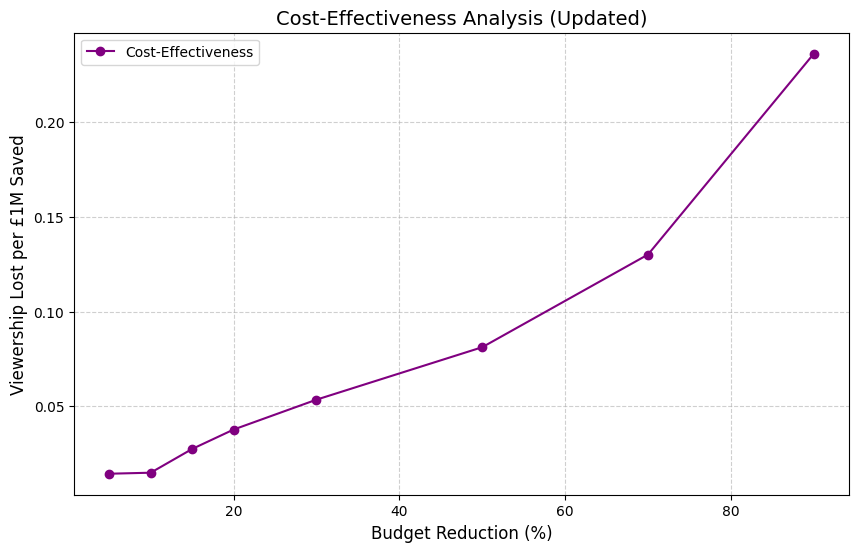

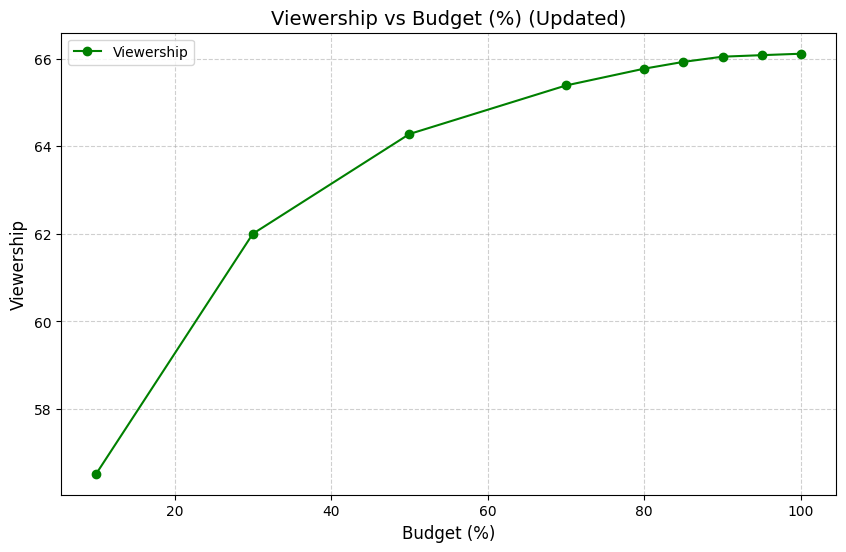

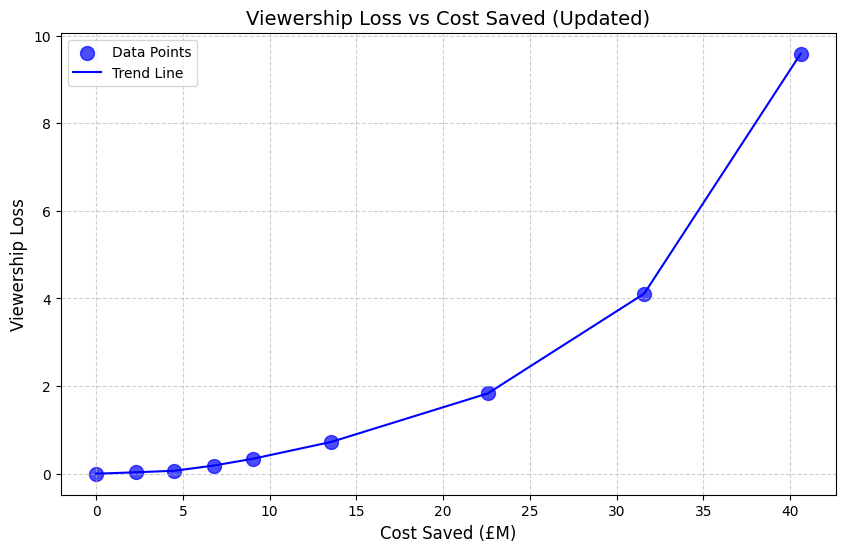

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Updated data based on user's selection
final_data = {
    "Budget (%)": [100, 95, 90, 85, 80, 70, 50, 30, 10],
    "Total Cost (£)": [
        45123607.08, 42843865.41, 40607467.68, 38348604.17, 
        36087760.81, 31581199.31, 22548967.58, 13532075.11, 4511133.4
    ],
    "Viewership": [
        66.11028431, 66.07737908, 66.04268361, 65.92397833, 
        65.76929438, 65.38562892, 64.27756837, 62.00072979, 56.52443664
    ]
}

# Convert to DataFrame
final_df = pd.DataFrame(final_data)

# Add derived columns
final_df["Budget Reduction (%)"] = (1 - final_df["Budget (%)"] / final_df["Budget (%)"].iloc[0]) * 100
final_df["Viewership Loss"] = final_df["Viewership"].iloc[0] - final_df["Viewership"]
final_df["Cost Saved (£)"] = final_df["Total Cost (£)"].iloc[0] - final_df["Total Cost (£)"]
final_df["Cost-Effectiveness (Viewership Lost / Cost Saved)"] = final_df["Viewership Loss"] / (final_df["Cost Saved (£)"] / 1e6)

# Visualization: Cost-Effectiveness
plt.figure(figsize=(10, 6))
plt.plot(
    final_df["Budget Reduction (%)"],
    final_df["Cost-Effectiveness (Viewership Lost / Cost Saved)"],
    marker="o",
    color="purple",
    label="Cost-Effectiveness"
)
plt.title("Cost-Effectiveness Analysis (Updated)", fontsize=14)
plt.xlabel("Budget Reduction (%)", fontsize=12)
plt.ylabel("Viewership Lost per £1M Saved", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Visualization: Viewership vs Budget
plt.figure(figsize=(10, 6))
plt.plot(
    final_df["Budget (%)"],
    final_df["Viewership"],
    marker="o",
    color="green",
    label="Viewership"
)
plt.title("Viewership vs Budget (%) (Updated)", fontsize=14)
plt.xlabel("Budget (%)", fontsize=12)
plt.ylabel("Viewership", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Visualization: Combined Analysis
plt.figure(figsize=(10, 6))
plt.scatter(
    final_df["Cost Saved (£)"] / 1e6,
    final_df["Viewership Loss"],
    c="blue",
    s=100,
    alpha=0.7,
    label="Data Points"
)
plt.plot(
    final_df["Cost Saved (£)"] / 1e6,
    final_df["Viewership Loss"],
    color="blue",
    label="Trend Line"
)
plt.title("Viewership Loss vs Cost Saved (Updated)", fontsize=14)
plt.xlabel("Cost Saved (£M)", fontsize=12)
plt.ylabel("Viewership Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


## 3. 10 scenarios (to test model robustness)

In [284]:
# 从result中提取变量结果（更快）
fixed_movie_slot = defaultdict(float)
fixed_ad_slot = defaultdict(float)

filename = '3days_results_comp70.txt'
# 打开并读取Xpress结果文件
with open(filename, "r", encoding="utf-8") as file:
    lines = file.readlines()

# 提取变量和值的逻辑
solution_start = False
for line in lines:
    # 检测Solution部分的开始
    if line.strip() == "Solution:":
        solution_start = True
        continue

    # 开始提取以 slot 开头的变量和值
    if solution_start:
        if ":" in line:
            variable, value = line.split(":")
            variable = variable.strip()  # 清理变量名
            value = float(value.strip())  # 转换值为浮点数
            
            # 仅处理以 slot 开头的变量
            if variable.startswith("slot") and round(value) > 0:
                # 将符合条件的变量和值存入列表
                s = int(variable.split('_')[1])
                m = int(variable.split('_')[-1])
                fixed_movie_slot[(s, m)] = round(value)
            
            # 仅处理以 ad 开头的变量
            if variable.startswith("ad") and round(value) > 0:
                # 从变量名中提取类别（c）的逻辑
                c = int(variable.split('_')[1])
                s = int(variable.split('_')[2])
                m = int(variable.split('_')[-1])
                fixed_ad_slot[(c, s, m)] = round(value)

In [285]:
truth_others = [i for i in range(10) if i != truth_random]

obj_res = []
for line in lines:
    if line.startswith("Objective Value:"):
        obj_res.append(line.split(':')[-1].strip())
        break

slot_arrange_values = {(s, m): fixed_movie_slot[(s, m)] for s in slots_A for m in movies}
ad_arrange_values = {(c, s, m): fixed_ad_slot[(c, s, m)] for c, s in c_s_list for m in movies}

fixed_slot_arrange = {(s, m): value for (s, m), value in slot_arrange_values.items()}
fixed_ad_arrange = {(c, s, m): value for (c, s, m), value in ad_arrange_values.items()}

In [124]:
for i in range(9):
    # truth = expected_list[i]
    truth = pd.DataFrame({
        'Channel0': list(channel0.loc[:, ['children_true_view_count_' + str(truth_others[i]), 'adults_true_view_count_' + str(truth_others[i]), 'retirees_true_view_count_' + str(truth_others[i])]].sum(1)),
        'Channel1': list(channel1.loc[:, ['children_true_view_count_' + str(truth_others[i]), 'adults_true_view_count_' + str(truth_others[i]), 'retirees_true_view_count_' + str(truth_others[i])]].sum(1)),
        'Channel2': list(channel2.loc[:, ['children_true_view_count_' + str(truth_others[i]), 'adults_true_view_count_' + str(truth_others[i]), 'retirees_true_view_count_' + str(truth_others[i])]].sum(1))
    })
    new_prob = xp.problem('problem')
    new_prob.setObjective(
        xp.Sum((1 - competition_factors[s]) * expectedA[s][m] * fixed_slot_arrange[s, m] for s in slots_A for m in movies) +
        xp.Sum(fixed_ad_arrange[c, s, m] * find_conversion_rate(c, s, m) * truth.iloc[s, c] for c, s in c_s_list for m in movies),
        sense=xp.maximize
    )
    new_prob.solve()
    obj_res.append(new_prob.getObjVal())

FICO Xpress v9.4.3, Hyper, solve started 23:42:01, Nov 23, 2024
Heap usage: 387KB (peak 387KB, 76MB system)
Maximizing LP noname using up to 11 threads and up to 18GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
         0 rows            0 cols            0 elements
Presolved problem has:
         0 rows            0 cols            0 elements
Presolve finished in 0 seconds
Heap usage: 387KB (peak 387KB, 76MB system)
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0         65.148932      D      0     0        .000000     0
Uncrunching matrix
Optimal solution found
Dual solved problem
  0 simplex iterations in 0.00 seconds at time 0

Final objective                       : 6.514893190046321e+01
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max dual violation        (abs/rel) :       0.0 /       0.0
  Max complementarity viol. (abs/rel) :       0.0 /      

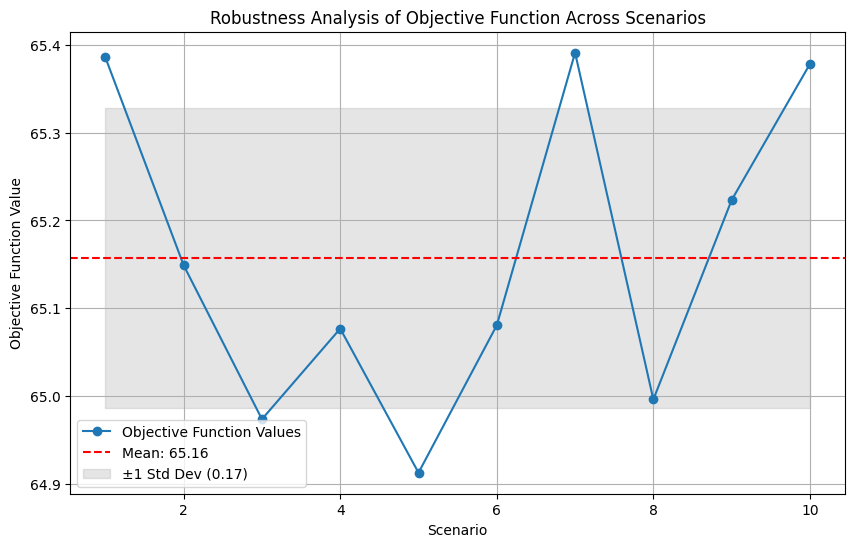

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

objective_values = [float(value) for value in obj_res]

# 场景编号
scenarios = list(range(1, len(objective_values) + 1))

# 计算统计信息
mean_value = np.mean(objective_values)
std_dev = np.std(objective_values)

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(scenarios, objective_values, marker='o', label='Objective Function Values')
plt.axhline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.fill_between(scenarios, mean_value - std_dev, mean_value + std_dev, color='gray', alpha=0.2, label=f'±1 Std Dev ({std_dev:.2f})')

# 标注
plt.title('Robustness Analysis of Objective Function Across Scenarios')
plt.xlabel('Scenario')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid()

# 显示图表
plt.show()


## 4. Advertisment related model

### 4.1 advertisement pricing model

In [439]:
channelA_prob = channelA.copy()
channelA_prob['content'] = [0] * len(channelA)
channelA_prob['ad_slot_price'] = [None] * len(channelA)
channelA_prob['mean_conversion_rate'] = [None] * len(channelA)
i = 0
while i < len(res_slot):
    slot, title = res_slot[i]
    channelA_prob['content'][6*i: 6*i+6] = [title] * 6
    i += 1

/var/folders/th/3vtt05957_l2_90vqr26g_dr0000gn/T/ipykernel_98521/2720999272.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  channelA_prob['content'][6*i: 6*i+6] = [title] * 6
/var/folders/th/3vtt05957_l2_90vqr26g_dr0000gn/T/ipykernel_985

In [440]:
from collections import Counter
res_ana = Counter([i[1] for i in res_slot])
i = 0
ad_slotA_dict = defaultdict(list)
while i < len(res_slot):
    slot, title = res_slot[i]
    slot_format = '%Y-%m-%d %H:%M:%S'
    slot = datetime.strptime(slot, slot_format)
    slot += timedelta(minutes=5)
    slot = str(slot)
    max_conversion_rate = 0.35 # expected.iloc[s, c]
    conversion_rate = calculate_conversion_rate(
        channelA_prob, all_movie_df, unique_genres, slot, movie, max_conversion_rate
    )
    channelA_prob['mean_conversion_rate'][slot_mapping5_inv[slot]] = conversion_rate
    ad_slotA_dict[title].append(str(slot))
    i += 1


ad_slotA = []
for movie in ad_slotA_dict.keys():
    if movie_df.query('title == @movie').n_ad_breaks.values[0] == res_ana[movie] - 1:
        ad_slotA_dict[movie] = ad_slotA_dict[movie][:-1]
    if movie_df.query('title == @movie').n_ad_breaks.values[0] != len(ad_slotA_dict[movie]):
        print('error', slot, title)
    else:
        ad_slotA.extend(ad_slotA_dict[movie])
    for slot in ad_slotA_dict[movie]:
        s = slot_mapping5_inv[slot]
        m = movies_mapping_inv[movie]
        basic_price = license_fee[m] / movie_df.query('title == @movie').n_ad_breaks * channelA.iloc[s].prime_time_factor
        viewership = expectedA[s//6][m] / 6 + \
            np.sum([fixed_ad_arrange[(c, s, m)] * find_conversion_rate(c, s, m) * expected.iloc[s, c] for c, s in c_s_list]) / 6
        CPM = 5
        add_price = (1 - competition_factor[s//6]) * viewership * CPM / 1000
        channelA_prob['ad_slot_price'][s] = add_price + basic_price.values[0]
        channelA_prob['content'][s] = 'Advert'

/var/folders/th/3vtt05957_l2_90vqr26g_dr0000gn/T/ipykernel_98521/3757550133.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  channelA_prob['mean_conversion_rate'][slot_mapping5_inv[slot]] = conversion_rate
/var/folders/th/3vtt05957_l2_90

### 4.2 The probability model for selling ads

/var/folders/th/3vtt05957_l2_90vqr26g_dr0000gn/T/ipykernel_98521/641949717.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel0_prob['mean_conversion_rate'] = channel0_conversion.iloc[:, :].apply(calculate_mean_rate, axis=1)
/var/folders/th/3vtt05957_l2_90vqr26g_dr0000gn/T/ipykernel_98521/641949717.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel1_prob['mean_conversion_rate'] = channel1_conversion.iloc[:, :].apply(calculate_mean_rate, axis=1)
/var/folders/th/3vtt05957_l2_90vqr26g_dr0000

XGBoost Accuracy: 0.9824561403508771
XGBoost AUC-ROC: 1.0
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.92      1.00      0.96        12

    accuracy                           0.98        57
   macro avg       0.96      0.99      0.97        57
weighted avg       0.98      0.98      0.98        57



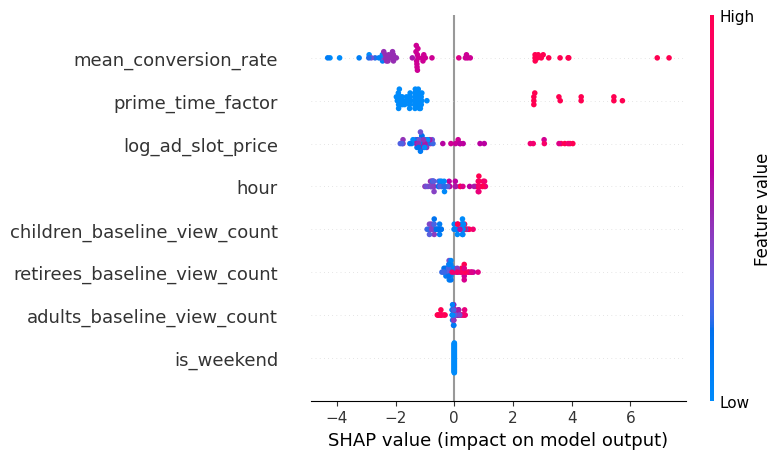

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import shap

# channels
channel0_prob = channel0[channel0['content'] == 'Advert']
channel1_prob = channel1[channel1['content'] == 'Advert']
channel2_prob = channel2[channel2['content'] == 'Advert']

# Step 1: 特征工程
# 计算广告位的整体转化率
def calculate_mean_rate(row):
    non_zero_values = row[row > 0]
    if len(non_zero_values) > 0:
        return non_zero_values.mean()
    else:
        return 0

# 示例数据
# channel0_conversion, channel1_conversion, channel2_conversion 需要替换为实际数据
channel0_prob['mean_conversion_rate'] = channel0_conversion.iloc[:, :].apply(calculate_mean_rate, axis=1)
channel1_prob['mean_conversion_rate'] = channel1_conversion.iloc[:, :].apply(calculate_mean_rate, axis=1)
channel2_prob['mean_conversion_rate'] = channel2_conversion.iloc[:, :].apply(calculate_mean_rate, axis=1)

# 合并数据
channels_prob = pd.concat([channel0_prob, channel1_prob, channel2_prob], axis=0)
channels_prob["log_ad_slot_price"] = np.log1p(channels_prob["ad_slot_price"])  # 对价格取对数
channels_prob["hour"] = pd.to_datetime(channels_prob.index).hour  # 提取小时信息
channels_prob["is_weekend"] = pd.to_datetime(channels_prob.index).weekday >= 5  # 是否为周末


# 方法 1: 加权组合分数
from sklearn.preprocessing import StandardScaler

# 初始化标准化器
scaler = StandardScaler()

# 选择需要标准化的列
columns_to_scale = ["mean_conversion_rate", "log_ad_slot_price", "prime_time_factor", "is_weekend"]

# 对数据进行标准化
channels_prob[columns_to_scale] = scaler.fit_transform(channels_prob[columns_to_scale])

# 计算加权组合分数（标准化后）
channels_prob["combined_score"] = (
    0.4 * channels_prob["mean_conversion_rate"] +
    0.3 * channels_prob["log_ad_slot_price"] +
    0.2 * channels_prob["prime_time_factor"] +
    0.1 * channels_prob["is_weekend"]
)


# 使用加权分数的75%百分位数作为阈值
threshold = np.percentile(channels_prob["combined_score"], 75)
channels_prob["is_sold_combined"] = (channels_prob["combined_score"] > threshold).astype(int)

# 特征选择
features = [
    "children_baseline_view_count", 
    "adults_baseline_view_count", 
    "retirees_baseline_view_count", 
    "prime_time_factor", 
    "log_ad_slot_price", 
    "mean_conversion_rate", 
    "hour", 
    "is_weekend"
]
target = "is_sold_combined"

X = channels_prob[features]
y = channels_prob[target]

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: 使用 XGBoost 模型
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# XGBoost 评估
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 评估指标
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost AUC-ROC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))

# 绘制 SHAP 图
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

# 保存预测结果
predictions = pd.DataFrame({
    "Actual": y_test,
    "XGBoost Predicted": y_pred_xgb,
    "XGBoost Probability": y_pred_proba_xgb,
})
predictions.to_csv("ad_slot_predictions_comparison.csv", index=False)
print("预测结果已保存到 ad_slot_predictions_comparison.csv")

In [ ]:
channelA_prob = channelA_prob[channelA_prob['content'] == 'Advert']
channelA_prob["log_ad_slot_price"] = np.log1p(np.array(channelA_prob["ad_slot_price"], dtype = np.float64))  # 对价格取对数
channelA_prob["hour"] = pd.to_datetime(channelA_prob.index).hour  # 提取小时信息
channelA_prob["is_weekend"] = pd.to_datetime(channelA_prob.index).weekday >= 5  # 是否为周末

# 对新数据的特征进行预处理（与训练数据一致）
# 提取需要的特征
features = [
    "children_baseline_view_count", 
    "adults_baseline_view_count", 
    "retirees_baseline_view_count", 
    "prime_time_factor", 
    "log_ad_slot_price", 
    "mean_conversion_rate", 
    "hour", 
    "is_weekend"
]

new_data_processed = channelA_prob[features]

# 如果训练数据经过标准化，则对新数据也进行标准化
scaler = StandardScaler()  # 替换为训练时使用的标准化器
scaler.fit(X)  # 使用训练集 X 的标准化参数
new_data_scaled = scaler.transform(new_data_processed)

predictions_proba = xgb_model.predict_proba(new_data_scaled)[:, 1]  # 预测概率
predictions = xgb_model.predict(new_data_scaled)  # 预测类别

# 将预测结果添加到新数据中
channelA_prob["predicted_probability"] = predictions_proba
channelA_prob["predicted_is_sold"] = predictions

# 保存预测结果
channelA_prob.to_csv("new_ad_slot_predictions.csv", index=True)
print("预测完成，结果已保存到 new_ad_slot_predictions.csv")
sum(channelA_prob['predicted_is_sold']), len(channelA_prob)

预测完成，结果已保存到 new_ad_slot_predictions.csv


(44, 97)

In [526]:
45123607.08 * 0.7

31586524.955999997

## 5. Price-related analysis
The minimum operating cost

In [528]:
operating_cost = []

for threshold in np.arange(0.5, 1.05, 0.05):
    budget = 45123607.08 * 0.7
    sell_ad = channelA_prob[channelA_prob['predicted_probability'] > threshold]
    revenue = sum(sell_ad['ad_slot_price'])
    cost = license_fees + ad_cost

    benefit = revenue + budget - cost
    operating_cost.append([round(threshold, 2), revenue+budget, cost, benefit])
    # print('threshold:', round(threshold, 2), 'revenue:', revenue + budget, 'cost:', cost, 'benefit:', benefit)

    print('threshold:', round(threshold, 2), 'revenue:', revenue)
operating = pd.DataFrame(operating_cost, columns=['threshold', 'revenue', 'cost', 'benefit'])
operating.to_csv('operating_cost.csv')

threshold: 0.5 revenue: 4592971.656113646
threshold: 0.55 revenue: 4325508.552784782
threshold: 0.6 revenue: 3897611.4598297253
threshold: 0.65 revenue: 3102704.7619818253
threshold: 0.7 revenue: 3102704.7619818253
threshold: 0.75 revenue: 3102704.7619818253
threshold: 0.8 revenue: 2958978.9812460504
threshold: 0.85 revenue: 1542658.9596398124
threshold: 0.9 revenue: 901383.4965019604
threshold: 0.95 revenue: 901383.4965019604
threshold: 1.0 revenue: 0


### Fuzzy

In [420]:
from collections import Counter
res_ana = Counter([i[1] for i in res_slot])
i = 0
ad_slotA_dict = defaultdict(list)
while i < len(res_slot):
    slot, title = res_slot[i]
    slot_format = '%Y-%m-%d %H:%M:%S'
    slot = datetime.strptime(slot, slot_format)
    slot += timedelta(minutes=20)
    ad_slotA_dict[title].append(str(slot))
    i += 1

ad_slotA = []
for m in ad_slotA_dict.keys():
    if movie_df.query('title == @m').n_ad_breaks.values[0] == res_ana[m] - 1:
        ad_slotA_dict[m] = ad_slotA_dict[m][:-1]
    if movie_df.query('title == @m').n_ad_breaks.values[0] != len(ad_slotA_dict[m]):
        print('error', slot, title)
    else:
        ad_slotA.extend(ad_slotA_dict[m])

In [421]:
# check: number of ad slots
ad_length = 0
for m in res_ana.keys():
    ad_length += movie_df.query('title == @m').n_ad_breaks.values[0]
ad_length == len(ad_slotA)

True

In [ ]:
# NDA数据

nda_lowest = np.floor((movie_df['runtime'] + movie_df['n_ad_breaks']*5)/ 30)
nda_highest = np.ceil((movie_df['runtime'] + movie_df['n_ad_breaks']*5)/30)
nda_central = [int(i/30) for i in movie_df['runtime_with_ads']]
nda = pd.DataFrame({
    'lowest': nda_lowest,
    'central': nda_central,
    'highest': nda_highest
}, dtype=int)


In [423]:
aud_truth_day = defaultdict(lambda: defaultdict(list))
for slot, title in res_slot:
    sa = slot_mapping30_inv[slot]
    day = sa // 34
    day_slot = sa % 34
    m = movies_mapping_inv[title]
    for i in range(9):
        # truth = expected_list[i]
        truth = pd.DataFrame({
            'Channel0': list(channel0.loc[:, ['children_true_view_count_' + str(truth_others[i]), 'adults_true_view_count_' + str(truth_others[i]), 'retirees_true_view_count_' + str(truth_others[i])]].sum(1)),
            'Channel1': list(channel1.loc[:, ['children_true_view_count_' + str(truth_others[i]), 'adults_true_view_count_' + str(truth_others[i]), 'retirees_true_view_count_' + str(truth_others[i])]].sum(1)),
            'Channel2': list(channel2.loc[:, ['children_true_view_count_' + str(truth_others[i]), 'adults_true_view_count_' + str(truth_others[i]), 'retirees_true_view_count_' + str(truth_others[i])]].sum(1))
        })
        conv_m = 0
        for c, s in c_s_list:
            conv_m += fixed_ad_arrange[c, s, m] * find_conversion_rate(c, s, m) * truth.iloc[s, c]
        aud_truth_day[day][i+1].append([conv_m + competition_factors[sa] * expectedA[sa][m] * fixed_slot_arrange[sa, m] / res_ana[title], title])

aud_base_day = defaultdict(list)
for slot, title in res_slot:
    sa = slot_mapping30_inv[slot]
    day = sa // 34
    day_slot = sa % 34
    m = movies_mapping_inv[title]
    conv_m = 0
    for c, s in c_s_list:
        conv_m += fixed_ad_arrange[c, s, m] * find_conversion_rate(c, s, m) * expected.iloc[s, c]
    aud_base_day[day].append([conv_m + competition_factors[sa] * expectedA[sa][m] * fixed_slot_arrange[sa, m] / res_ana[title], title])

In [424]:
aud_m_ttr = defaultdict(list)
for i in range(9):
    top10 = []
    for d in range(days):
        top10.extend([i[1] for i in sorted(aud_truth_day[d][i+1])][-10:])
    tmp_dict = Counter(top10)
    for m in tmp_dict.keys():
        aud_m_ttr[m].append(tmp_dict[m])

aud_m_au = defaultdict(list)
for i in range(9):
    top10 = defaultdict(float)
    for d in range(days):
        for k, v in sorted(aud_truth_day[d][i+1])[-10:]:
            top10[v] += k
    for m in tmp_dict.keys():
        aud_m_au[m].append(top10[m])

In [425]:
ttr_highest = defaultdict(float)
ttr_lowest = defaultdict(float)
for m in res_ana.keys():
    if m in aud_m_ttr.keys():
        ttr_highest[m] = max(aud_m_ttr[m])
        ttr_lowest[m] = min(aud_m_ttr[m])
        
top10 = []
for d in range(days):
    top10.extend([i[1] for i in sorted(aud_base_day[d])][-10:])
ttr_central = Counter(top10)

au_highest = defaultdict(float)
au_lowest = defaultdict(float)
for m in res_ana.keys():
    if m in aud_m_au.keys():
        au_highest[m] = max(aud_m_au[m])
        au_lowest[m] = min(aud_m_au[m])
au_central = defaultdict(float)
for d in range(days):
    for k, v in sorted(aud_base_day[d])[-10:]:
        au_central[v] += k

In [ ]:
import numpy as np
import skfuzzy as fuzz

def triangular_fuzzy_number(low, center, high):
    # 生成x轴范围，比最低和最高预测值稍宽一些
    x = np.arange(low - 10, high + 10, 1)
    # 使用skfuzzy的trimf函数创建三角形模糊数
    if center > high:
        high = center
    if center < low:
        low = center
    return fuzz.trimf(x, [low, center, high]), (low, center, high)

def defuzzify_delgado(fuzzy_number, params):
    low, center, high = params
    # Delgado方法: V(F˜i) = a2i + (a3i − 2a2i + a1i) / 6
    # return center + (high - 2 * center + low) / 6
    return (center + low + high) / 3

def calculate_audience_expectation(ndai, ttri, aui):
    # 创建三角形模糊数
    nda_fuzzy, nda_params = triangular_fuzzy_number(ndai['low'], ndai['center'], ndai['high'])
    ttr_fuzzy, ttr_params = triangular_fuzzy_number(ttri['low'], ttri['center'], ttri['high'])
    au_fuzzy, au_params = triangular_fuzzy_number(aui['low'], aui['center'], aui['high'])
    
    # 去模糊化
    v_nda = defuzzify_delgado(nda_fuzzy, nda_params)
    v_ttr = defuzzify_delgado(ttr_fuzzy, ttr_params)
    v_au = defuzzify_delgado(au_fuzzy, au_params)
    
    # 计算 h_i
    # h_i = V(TT R˜i) * V(A U˜i) / V(NDA˜i)
    h_i = v_ttr * v_au / v_nda
    return h_i

# 假设我们有多个广播，每个广播都有三个三角形模糊数
broadcasts = []
for m in res_ana.keys():
    tmp_dict = {}
    tmp_dict['title'] = m
    tmp_dict['NDA'] = {'low': nda.iloc[movies_mapping_inv[m]].values[0], 'center': nda.iloc[movies_mapping_inv[m]].values[1], 'high': nda.iloc[movies_mapping_inv[m]].values[2]}
    tmp_dict['TTR'] = {'low': ttr_lowest[m], 'center': ttr_central[m], 'high': ttr_highest[m]}
    tmp_dict['AU'] = {'low': au_lowest[m], 'center': au_central[m], 'high': au_highest[m]}
    broadcasts.append(tmp_dict)

# 对每个广播计算观众预期的近似清晰值 h_i
hi_list = {}
for broadcast in broadcasts:
    h_i = calculate_audience_expectation(broadcast['NDA'], broadcast['TTR'], broadcast['AU'])
    print(f"{broadcast['title']} 的观众预期的近似清晰值 h_i: {h_i}")
    hi_list[broadcast['title']] = (h_i)

Project X 的观众预期的近似清晰值 h_i: 0.0233430584672274
Fight Club 的观众预期的近似清晰值 h_i: 0.01071269085854893
Me Before You 的观众预期的近似清晰值 h_i: 0.035148146225361866
Fifty Shades Freed 的观众预期的近似清晰值 h_i: 0.02613765499710122
The Hangover 的观众预期的近似清晰值 h_i: 0.00974089064306886
Forrest Gump 的观众预期的近似清晰值 h_i: 0.0
Saw 的观众预期的近似清晰值 h_i: 0.0
Saw II 的观众预期的近似清晰值 h_i: 0.0
Mean Girls 的观众预期的近似清晰值 h_i: 0.24940241838218505
The Godfather Part II 的观众预期的近似清晰值 h_i: 0.0
After 的观众预期的近似清晰值 h_i: 0.009351744243869928
Scary Movie 的观众预期的近似清晰值 h_i: 0.0
Cruella 的观众预期的近似清晰值 h_i: 0.07739178504043802
The Shawshank Redemption 的观众预期的近似清晰值 h_i: 0.03804163963492874
The Conjuring: The Devil Made Me Do It 的观众预期的近似清晰值 h_i: 0.0
The Interview 的观众预期的近似清晰值 h_i: 0.1779319978038387
Hidden Figures 的观众预期的近似清晰值 h_i: 0.0
GoodFellas 的观众预期的近似清晰值 h_i: 0.023919112864032466
The Wolf of Wall Street 的观众预期的近似清晰值 h_i: 0.0
The Godfather 的观众预期的近似清晰值 h_i: 0.0
The Equalizer 的观众预期的近似清晰值 h_i: 0.11557253698536475
